Imports

In [1]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson, gamma
import arviz as az

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input parameters for scraping

In [2]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [3]:
scrap_games(years)

Read data

In [4]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)
print(seasons_games)

{2022:                      start_time              away_team  away_team_score  \
0     2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1     2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2     2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3     2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4     2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   
...                         ...                    ...              ...   
1318  2022-06-06 00:00:00+00:00         BOSTON CELTICS               88   
1319  2022-06-09 01:00:00+00:00  GOLDEN STATE WARRIORS              100   
1320  2022-06-11 01:00:00+00:00  GOLDEN STATE WARRIORS              107   
1321  2022-06-14 01:00:00+00:00         BOSTON CELTICS               94   
1322  2022-06-17 01:00:00+00:00  GOLDEN STATE WARRIORS              103   

                  home_team  home_team_score  
0           MILWAUKEE BUCKS              127 

Edit dataframe

In [5]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())
print(teams)
# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']


['MILWAUKEE BUCKS', 'LOS ANGELES LAKERS', 'CHARLOTTE HORNETS', 'DETROIT PISTONS', 'NEW YORK KNICKS', 'TORONTO RAPTORS', 'MEMPHIS GRIZZLIES', 'MINNESOTA TIMBERWOLVES', 'NEW ORLEANS PELICANS', 'SAN ANTONIO SPURS', 'UTAH JAZZ', 'PORTLAND TRAIL BLAZERS', 'PHOENIX SUNS', 'ATLANTA HAWKS', 'MIAMI HEAT', 'GOLDEN STATE WARRIORS', 'ORLANDO MAGIC', 'WASHINGTON WIZARDS', 'CLEVELAND CAVALIERS', 'PHILADELPHIA 76ERS', 'BOSTON CELTICS', 'HOUSTON ROCKETS', 'CHICAGO BULLS', 'DENVER NUGGETS', 'SACRAMENTO KINGS', 'INDIANA PACERS', 'LOS ANGELES CLIPPERS', 'BROOKLYN NETS', 'OKLAHOMA CITY THUNDER', 'DALLAS MAVERICKS']


Show data (first 5 rows)

In [6]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

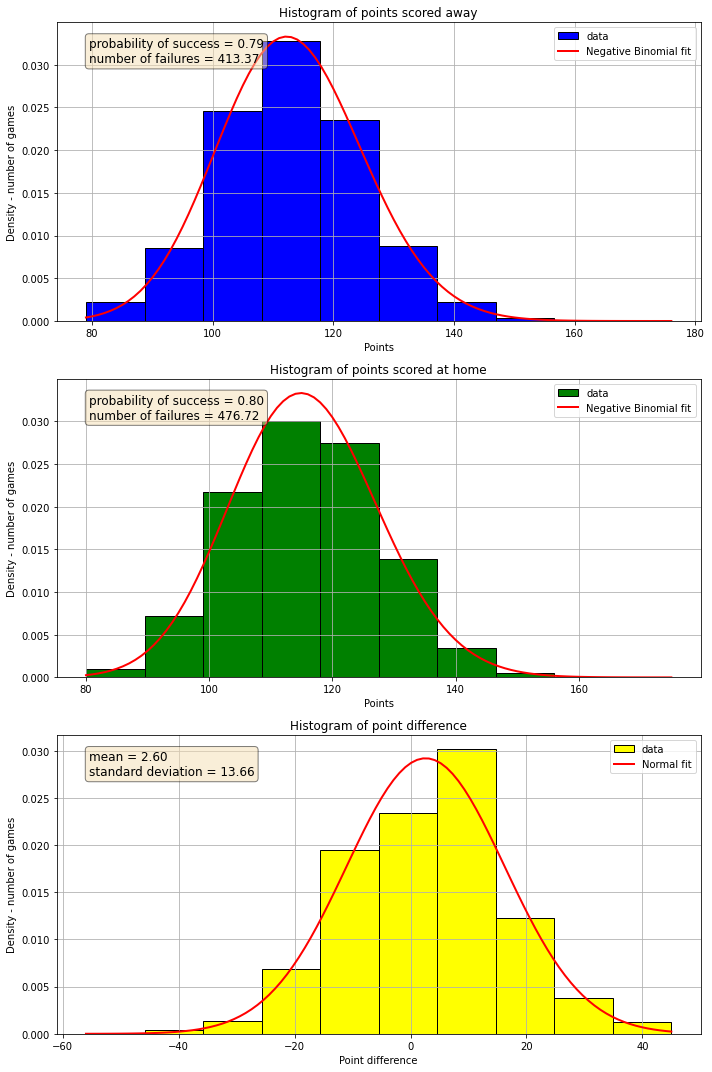

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    if col == 'difference':
        std = np.sqrt(var)
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'probability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [8]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

Modelling

## Model 1 - poisson

### Prior

In [9]:
model_normal_prior = CmdStanModel(stan_file='src/model/model_normal_prior.stan')
samples = 1000
sim_normal_prior=model_normal_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [10]:
mod_norm_pri = sim_normal_prior.draws_pd()
print(mod_norm_pri)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0         118.8230         131.7480      19.9601   
1      0.0            0.0          99.8102          80.8328      31.9430   
2      0.0            0.0         125.2740         106.1130      20.2866   
3      0.0            0.0         111.7330          88.7578      13.1116   
4      0.0            0.0         152.7200         112.0710      17.8548   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0         143.4770         128.6940      25.8658   
3996   0.0            0.0         149.3680         152.2400      20.2981   
3997   0.0            0.0         105.9900         121.3020      13.6771   
3998   0.0            0.0         148.6040         129.2100      21.9602   
3999   0.0            0.0          70.3948          86.9012      12.7319   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

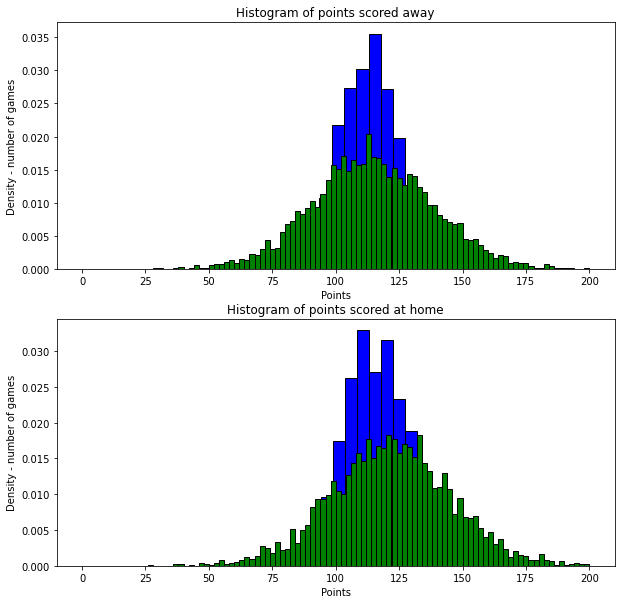

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_normal_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_normal_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

## MODEL 2

### Prior

In [12]:
model_nbinomial_prior = CmdStanModel(stan_file='src/model/model_nbinomial_prior.stan')
samples = 1000
sim_nbin_prior=model_nbinomial_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [13]:
mod_nbin_prior = sim_nbin_prior.draws_pd()
print(mod_nbin_prior)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0            118.0            113.0    -0.209008   
1      0.0            0.0             85.0             88.0     1.526440   
2      0.0            0.0            103.0            141.0     2.222320   
3      0.0            0.0            120.0             86.0    -0.448347   
4      0.0            0.0            109.0            175.0     0.869300   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0             90.0             88.0    -0.235241   
3996   0.0            0.0             83.0            132.0    -0.306715   
3997   0.0            0.0             69.0            139.0     1.910670   
3998   0.0            0.0             88.0            104.0     1.688990   
3999   0.0            0.0             78.0            103.0     1.443200   

      mu_away_att  mu_home_def  mu_away_def  sigma2_att  sigma2_def  phi_home  \
0     

Text(0, 0.5, 'Density - number of games')

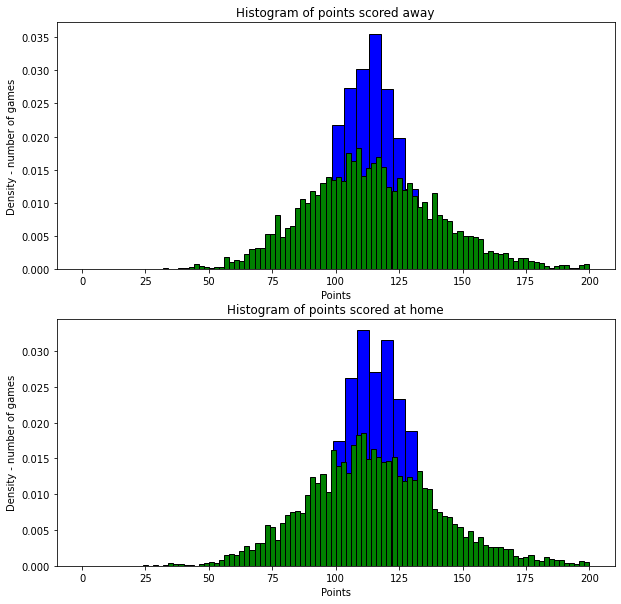

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nbin_prior.stan_variable('away_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nbin_prior.stan_variable('home_score_pred'), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [15]:
model_normal_posterior = CmdStanModel(stan_file='src/model/model_normal_posterior.stan')
samples = 10000
sim_nor_post=model_normal_posterior.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:25 Sampling completed                         


INFO:cmdstanpy:CmdStan done processing.


In [16]:
mod_norm_post = sim_nor_post.draws_pd()
print(mod_norm_post)

           lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -2267780.0            0.0     14.3855          0.0           1.0   
1    -2267780.0            0.0     14.3855          0.0           1.0   
2    -2267780.0            0.0     14.3855          0.0           1.0   
3    -2267780.0            0.0     14.3855          0.0           1.0   
4    -2267780.0            0.0     14.3855          0.0           1.0   
...         ...            ...         ...          ...           ...   
9995 -2267780.0            0.0     14.3855          0.0           1.0   
9996 -2267780.0            0.0     14.3855          0.0           1.0   
9997 -2267780.0            0.0     14.3855          0.0           1.0   
9998 -2267780.0            0.0     14.3855          0.0           1.0   
9999 -2267780.0            0.0     14.3855          0.0           1.0   

      divergent__   energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             1.0  2267850.0     -0.32522     0

In [17]:
print(max(sim_nor_post.stan_variable('mu_home_att')))

-0.32522


Text(0, 0.5, 'Density - number of games')

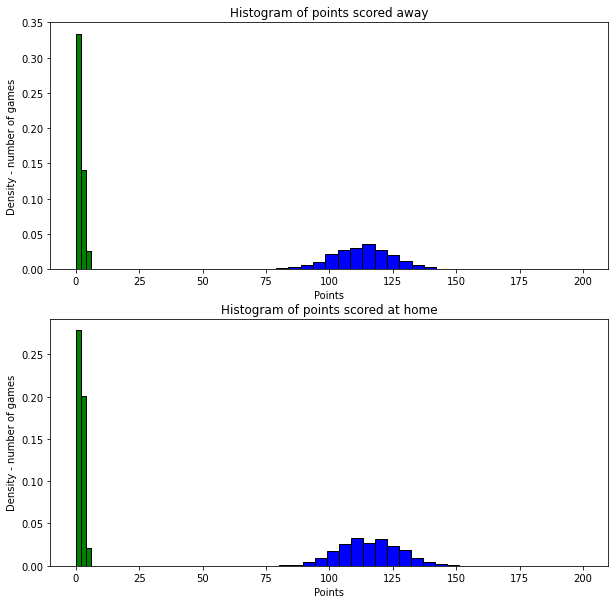

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_nor_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_nor_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [19]:
model_1_post = CmdStanModel(stan_file='src/model/model_1_posterior.stan')
samples = 10000
sim=model_1_post.sample(data=inp_data,
                     iter_sampling=samples,
                     iter_warmup=1,
                     chains=1
                     )

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:41 Sampling completed                         


INFO:cmdstanpy:CmdStan done processing.


In [20]:
mod_1_post = sim.draws_pd()
print(mod_1_post)

         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -18348.2            0.0     14.3855          0.0           1.0   
1    -18348.2            0.0     14.3855          0.0           1.0   
2    -18348.2            0.0     14.3855          0.0           1.0   
3    -18348.2            0.0     14.3855          0.0           1.0   
4    -18348.2            0.0     14.3855          0.0           1.0   
...       ...            ...         ...          ...           ...   
9995 -18348.2            0.0     14.3855          0.0           1.0   
9996 -18348.2            0.0     14.3855          0.0           1.0   
9997 -18348.2            0.0     14.3855          0.0           1.0   
9998 -18348.2            0.0     14.3855          0.0           1.0   
9999 -18348.2            0.0     14.3855          0.0           1.0   

      divergent__  energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             1.0   18412.8    -0.080612     0.216695    -0.678727  ... 

Text(0, 0.5, 'Density - number of games')

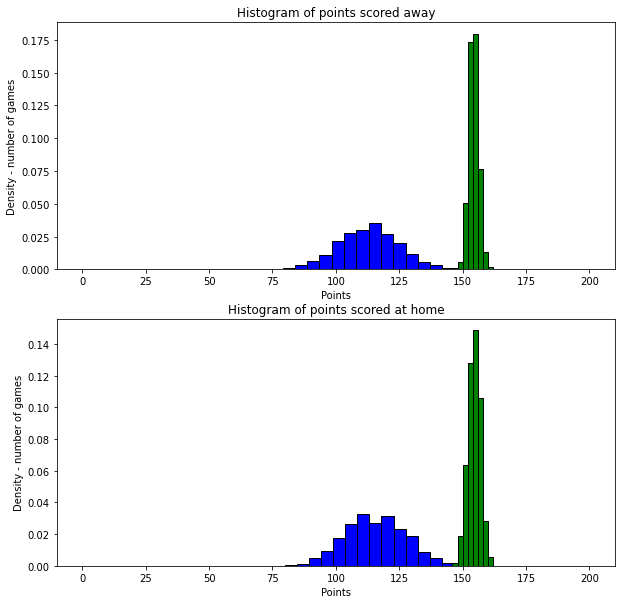

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [28]:
model_poiss_post = CmdStanModel(stan_file='src/model/model_poisson_posterior.stan')
samples = 1000
sim_poiss_post=model_poiss_post.sample(data=inp_data,
                     iter_sampling=samples,
                     #iter_warmup=1,
                     chains=4
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_poisson_posterior.stan to exe file /app/src/model/model_poisson_posterior
chain 1 |███████▏  | 06:28 Iteration:  7700 / 11000 [ 70%]  (Sampling)

chain 1 |███████▏  | 06:33 Iteration:  7800 / 11000 [ 70%]  (Sampling)

chain 1 |███████▎  | 06:38 Iteration:  7900 / 11000 [ 71%]  (Sampling)

chain 1 |███████▍  | 06:42 Iteration:  8000 / 11000 [ 72%]  (Sampling)

chain 1 |███████▌  | 06:46 Iteration:  8100 / 11000 [ 73%]  (Sampling)

chain 1 |███████▌  | 06:51 Iteration:  8200 / 11000 [ 74%]  (Sampling)

chain 1 |███████▋  | 06:55 Iteration:  8300 / 11000 [ 75%]  (Sampling)

chain 1 |███████▊  | 06:59 Iteration:  8400 / 11000 [ 76%]  (Sampling)

chain 1 |███████▊  | 07:03 Iteration:  8500 / 11000 [ 77%]  (Sampling)

chain 1 |███████▉  | 07:07 Iteration:  8600 / 11000 [ 78%]  (Sampling)

chain 1 |████████  | 07:12 Iteration:  8700 / 11000 [ 79%]  (Sampling)

chain 1 |████████▏ | 07:17 Iteration:  8800 / 11000 [ 80%]  (Sampling)

chain 


INFO:cmdstanpy:CmdStan done processing.


In [29]:
mod_poiss_post = sim_poiss_post.draws_pd()
print(mod_poiss_post)

           lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0     1081410.0       0.996716    0.026431          7.0         127.0   
1     1081410.0       0.779819    0.026431          7.0         127.0   
2     1081420.0       0.907394    0.026431          7.0         127.0   
3     1081410.0       0.998981    0.026431          7.0         127.0   
4     1081410.0       0.613059    0.026431          7.0         127.0   
...         ...            ...         ...          ...           ...   
3995  1081410.0       0.999307    0.027313          7.0         127.0   
3996  1081410.0       0.993794    0.027313          7.0         127.0   
3997  1081400.0       0.785913    0.027313          7.0         127.0   
3998  1081410.0       0.807073    0.027313          7.0         127.0   
3999  1081420.0       0.931140    0.027313          7.0         127.0   

      divergent__   energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             0.0 -1081350.0     0.000051    -0

Text(0, 0.5, 'Density - number of games')

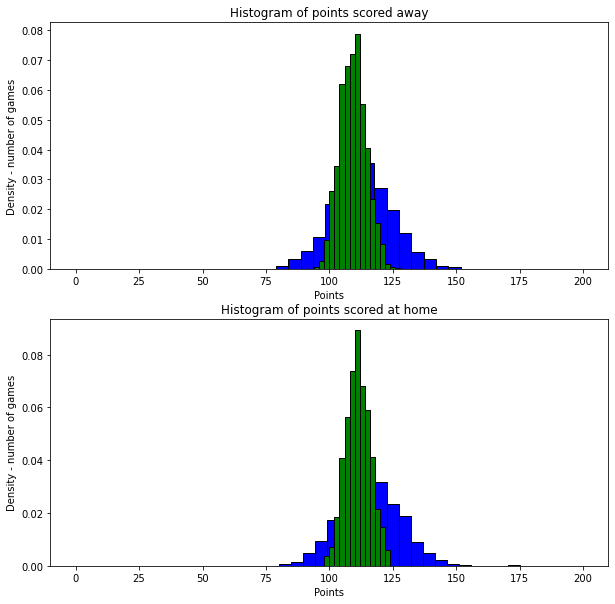

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[0].hist(sim_poiss_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=20, color='blue', edgecolor='black', label='data')
axes[1].hist(sim_poiss_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=100, color='green', edgecolor='black', label='data', range=(0, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


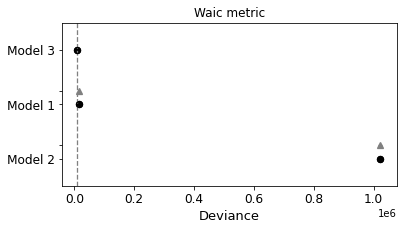

In [31]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nor_post, log_likelihood={"home": "log_lik_home"})
idata_normal = az.from_cmdstanpy(posterior=sim, log_likelihood={"home": "log_lik_home"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"home": "log_lik_home"})

# Comparing models
comp_dict = {'Model 1': idata_normal, 'Model 2': idata_nbin, "Model 3": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

/usr/local/lib/python3.12/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.12/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.12/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, o

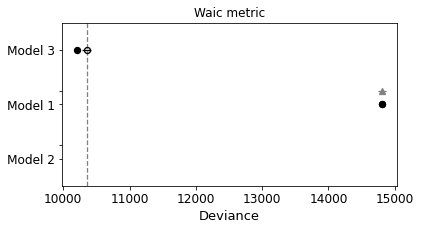

In [32]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nor_post, log_likelihood={"away": "log_lik_away"})
idata_normal = az.from_cmdstanpy(posterior=sim, log_likelihood={"away": "log_lik_away"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"away": "log_lik_away"})

# Comparing models
comp_dict = {'Model 1': idata_normal, 'Model 2': idata_nbin, "Model 3": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()